In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os

# change font
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
def get_results_df(phone_name, directory, vid, vid_compulsory=False):

    records = []
    records_chunks = []

    for file_name in os.listdir(directory):
    #     print(file_name)
        if vid_compulsory:
            stuff = re.search(r'log_video_' + vid + r'_(\d+)fps(\d+)p_([\d_]+)([nmc]{1})', file_name)
        else:
            stuff = re.search(r'log_video(?:_' + vid + r')?_(\d+)fps(\d+)p_([\d_]+)([nmc]{1})', file_name)

        if stuff == None:
            continue
        fps, res, mem_state, run_number = int(stuff.group(1)), int(stuff.group(2)), stuff.group(4), float(stuff.group(3).replace('_', '.'))

        with open(directory + '/' + file_name) as f:
            lines = list(f.readlines())
            # print(file_name, fps, run_number, len(lines))
            try:
                last_record = lines[-1].split('\t') # if len(lines) > 0 else "0\t0\t0\t0.0\t0\t0\t0\t0\t0\t0\t0"
            except IndexError as e:
                print(e)
                print(lines)
                print(vid, file_name)
            if len(last_record) != 11:
                print(f'error parsing {directory}/{file_name}')
            else:
                crashed = int(len(lines) != 45)
                remained_in_moderate = 0
                went_into_critical = 1 if mem_state == 'm' and crashed == 0 else 0
                remained_in_critical = 1 if mem_state == 'c' and crashed == 0 else 0
                situation = 'Remained in Normal'
                if crashed:
                    situation = 'Crashed'
                elif went_into_critical:
                    situation = 'Went into Critical'
                elif remained_in_critical:
                    situation = 'Remained in Critical'
                records.append([phone_name, float(last_record[0])*1000, mem_state, res, fps, int(run_number), int(last_record[-3]), int(last_record[-2]), crashed, len(lines), float(last_record[-4]), float(last_record[-9]), remained_in_moderate, went_into_critical, remained_in_critical, situation])

                count = 0
                for line in [line.split('\t') for line in lines]:
    #                 print(line)
                    if len(line) > 1:
                        records_chunks.append([phone_name, float(line[0])*1000, mem_state, res, fps, int(run_number), count,
                                        int(line[-3]),
                                       int(line[-2]),
                                       crashed,
                                       len(lines),
                                        float(line[-4]), float(line[-9]), float(line[-1]),
                                        remained_in_moderate, went_into_critical, remained_in_critical, situation])
                        count += 1
            
    raw_df = pd.DataFrame(records, columns=['Phone', 'timestamp','Mem. State', 'Resolution', 'FPS', 'Run No.', 'Dropped Frames', 'Total Frames', 'Crashed', 'Chunks', 'Time Elapsed (s)', 'Buffer (s)', 'Remained in Moderate', 'Went into Critical', 'Remained in Critical', 'Situation'])
    raw_df_chunks = pd.DataFrame(records_chunks, columns=['Phone', 'timestamp', 'Mem. State', 'Resolution', 'FPS', 'Run No.', 'Chunk No.', 'Dropped Frames', 'Total Frames', 'Crashed', 'Chunks', 'Time Elapsed (s)', 'Buffer (s)', 'Rendered FPS', 'Remained in Moderate', 'Went into Critical', 'Remained in Critical', 'Situation'])
    
    # normal df
    df = raw_df.sort_values(['Phone', 'Resolution', 'FPS', 'Mem. State', 'Run No.'])
    df['%age Frames Dropped'] = (df['Dropped Frames']/df['Total Frames'])*100

    # df chunks
    df_chunks = raw_df_chunks.sort_values(['Phone', 'Resolution', 'FPS', 'Mem. State', 'Run No.', 'Chunk No.'])
    df_chunks['%age Frames Dropped'] = (df_chunks['Dropped Frames']/df_chunks['Total Frames'])*100
    
    def change_mem_state_label(label):
        if label == 'n':
            return 'normal'
        elif label == 'm':
            return 'moderate'
        elif label == 'c':
            return 'critical'
        else:
            return label
        
    df['Mem. State'] = df['Mem. State'].apply(change_mem_state_label)
    df_chunks['Mem. State'] = df_chunks['Mem. State'].apply(change_mem_state_label)
    
    return df, df_chunks

In [25]:
bali_df , _ = get_results_df('nexus5', 'runs-bali', 'bali', vid_compulsory=False)
tennis_df , _ = get_results_df('nexus5', 'runs-tennis', 'tennis', vid_compulsory=False)
dubai_df , _ = get_results_df('nexus5', 'runs-dubai', 'dubai', vid_compulsory=False)
gaming_df , _ = get_results_df('nexus5', 'runs-gaming', 'gaming', vid_compulsory=True)
news_df , _ = get_results_df('nexus5', 'runs-news', 'news', vid_compulsory=True)

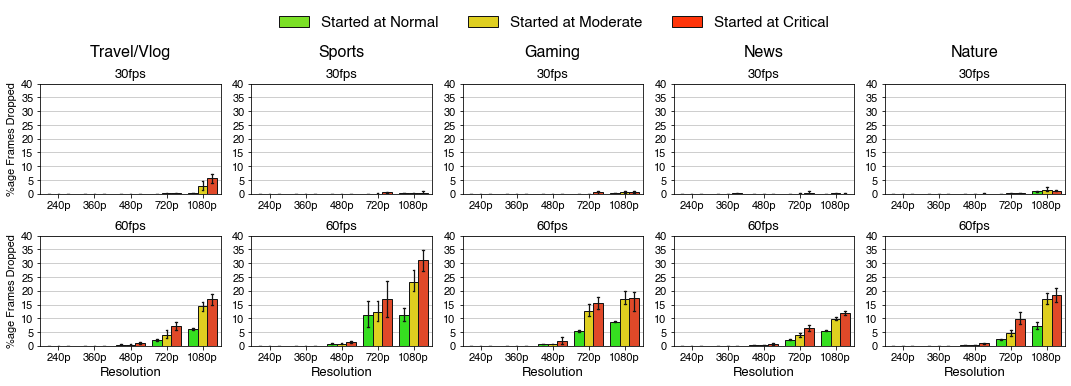

In [26]:
def plot_frames_dropped(ax, fps, df, genre, has_ylabel=False):
    
    sns.barplot(ax=ax, data=df.loc[df['FPS'] == fps].loc[df['Run No.'] >= 0], x='Resolution', y='%age Frames Dropped',
                hue='Mem. State',
                hue_order=['normal', 'moderate', 'critical'], 
                palette={'normal': '#1eff00', 'moderate': '#ffea00', 'critical': '#ff350a'},
                edgecolor='#141414', linewidth=1,
                capsize=.05, errwidth=1.25, errcolor='#141414')
                

    ax.set_title(f'{fps}fps', fontsize=13)
    
    if fps==30:
        ax.set_xlabel('', fontsize=13)
    else:
        ax.set_xlabel('Resolution', fontsize=13)
    
    if not has_ylabel:
        ax.set_ylabel('', fontsize=12)
    else:
        ax.set_ylabel('%age Frames Dropped', fontsize=11)

    # if fps == 30:
    #     pass
    #     ax.set_yticks(np.arange(0,101,10))
    #     ax.set_yticklabels(np.arange(0,101,10), rotation=0, fontsize=14)
    # else:
    ax.set_yticks(range(0,41,5))
    ax.set_yticklabels(range(0,41,5), rotation=0, fontsize=11)

    ax.set_xticks(range(0,5))

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=11)

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    ax.get_legend().remove()

    if fps == 30:
        ax.text(2, 50, genre, fontsize=16, horizontalalignment='center')

fig, ((ax1, ax3, ax5, ax7, ax9), (ax2, ax4, ax6, ax8, ax10)) = plt.subplots(2, 5, figsize=(15,5))

plot_frames_dropped(ax1, 30, dubai_df, 'Travel/Vlog', has_ylabel=True)
plot_frames_dropped(ax2, 60, dubai_df, 'Travel/Vlog', has_ylabel=True)

plot_frames_dropped(ax3, 30, tennis_df, 'Sports')
plot_frames_dropped(ax4, 60, tennis_df, 'Sports')

plot_frames_dropped(ax5, 30, gaming_df, 'Gaming')
plot_frames_dropped(ax6, 60, gaming_df, 'Gaming')

plot_frames_dropped(ax7, 30, news_df, 'News')
plot_frames_dropped(ax8, 60, news_df, 'News')

plot_frames_dropped(ax9, 30, bali_df, 'Nature')
plot_frames_dropped(ax10, 60, bali_df, 'Nature')


plt.tight_layout(h_pad=1)

# ax2.text(-0.66, 48, 'Bali Video [Low-Motion]', fontsize=20, horizontalalignment='center')
# ax4.text(-0.66, 48, 'Tennis Video [Medium-Motion]', fontsize=20, horizontalalignment='center')
# ax6.text(-0.66, 48, 'Dubai Video [High-Motion]', fontsize=20, horizontalalignment='center')

p1 = mpatches.Patch(color='#7BE026', label='Started at Normal', ec='#141414', lw=1)
p2 = mpatches.Patch(color='#DFCF21', label='Started at Moderate', ec='#141414', lw=1)
p3 = mpatches.Patch(color='#ff350a', label='Started at Critical', ec='#141414', lw=1)

ax3.legend(handles=[p1,p2,p3], bbox_to_anchor=(0.1, 1.7), loc=2, fontsize=15, borderaxespad=0., borderpad=0.6, ncol=3, frameon=False)

# plt.title('Frames Drop')

# plt.text(-0.595, 28, 'Frames Dropped when video eventually crashed', fontsize=20, horizontalalignment='center')

# ax1.text(2, 20, 'Frames Dropped', fontsize=25, horizontalalignment='center')

plt.savefig(f"./nexus5_diff_videos.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.0)

# ax = sns.barplot(data=df_60fps, x='Resolution', y='%age Frames Dropped', hue='Mem. State')

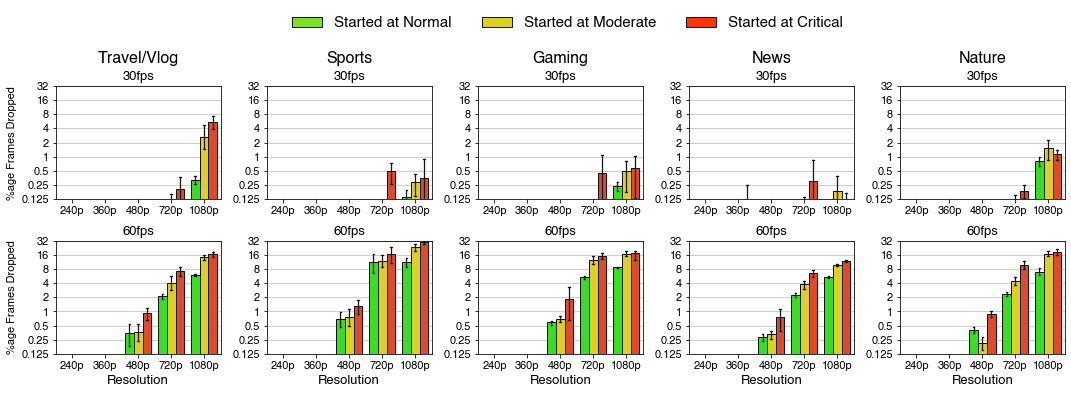

In [27]:
def plot_frames_dropped(ax, fps, df, genre, has_ylabel=False):
    
    sns.barplot(ax=ax, data=df.loc[df['FPS'] == fps].loc[df['Run No.'] >= 0], x='Resolution', y='%age Frames Dropped',
                hue='Mem. State',
                hue_order=['normal', 'moderate', 'critical'], 
                palette={'normal': '#1eff00', 'moderate': '#ffea00', 'critical': '#ff350a'},
                edgecolor='#141414', linewidth=1,
                capsize=.05, errwidth=1.25, errcolor='#141414')
                

    ax.set_title(f'{fps}fps', fontsize=13)
    
    if fps==30:
        ax.set_xlabel('', fontsize=13)
    else:
        ax.set_xlabel('Resolution', fontsize=13)
    
    if not has_ylabel:
        ax.set_ylabel('', fontsize=12)
    else:
        ax.set_ylabel('%age Frames Dropped', fontsize=11)

    ax.set_yscale('log', base=2, subs=[1, 2, 3])

    ax.set_ylim(0.125, 32)

    ax.set_yticks([0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32])
    ax.set_yticklabels([0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32], rotation=0, fontsize=11)

    ax.set_xticks(range(0,5))

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=11)

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    ax.get_legend().remove()

    if fps == 30:
        ax.text(2, 100, genre, fontsize=16, horizontalalignment='center')

fig, ((ax1, ax3, ax5, ax7, ax9), (ax2, ax4, ax6, ax8, ax10)) = plt.subplots(2, 5, figsize=(15,5))

plot_frames_dropped(ax1, 30, dubai_df, 'Travel/Vlog', has_ylabel=True)
plot_frames_dropped(ax2, 60, dubai_df, 'Travel/Vlog', has_ylabel=True)

plot_frames_dropped(ax3, 30, tennis_df, 'Sports')
plot_frames_dropped(ax4, 60, tennis_df, 'Sports')

plot_frames_dropped(ax5, 30, gaming_df, 'Gaming')
plot_frames_dropped(ax6, 60, gaming_df, 'Gaming')

plot_frames_dropped(ax7, 30, news_df, 'News')
plot_frames_dropped(ax8, 60, news_df, 'News')

plot_frames_dropped(ax9, 30, bali_df, 'Nature')
plot_frames_dropped(ax10, 60, bali_df, 'Nature')


plt.tight_layout(h_pad=1)

p1 = mpatches.Patch(color='#7BE026', label='Started at Normal', ec='#141414', lw=1)
p2 = mpatches.Patch(color='#DFCF21', label='Started at Moderate', ec='#141414', lw=1)
p3 = mpatches.Patch(color='#ff350a', label='Started at Critical', ec='#141414', lw=1)

ax3.legend(handles=[p1,p2,p3], bbox_to_anchor=(0.1, 1.7), loc=2, fontsize=15, borderaxespad=0., borderpad=0.6, ncol=3, frameon=False)

plt.savefig(f"./nexus5_diff_videos.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.0)